In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

# Clustering

##### Version 0.2

***
By AA Miller (Northwestern/CIERA)

10 Sep 2023

In this notebook, the two clustering methods discussed in [Lecture II](https://github.com/LSSTC-DSFP/Session-19/tree/main/day1/IntroductionToUnsupervisedLearning.ipynb), [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) and [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN), are used to perform clustering on the famous Iris data set. Using these algorithms it will be shown that identifying accurate clusters when labels are not present is challenging even with a small, low-dimensional, few-class data set.

The notebook closes with a challenge problem using actual astronomical data (photometric measurements of galaxies in the SDSS data set) to attempt clustering on real world data where there are no labeled clusters that are known a priori.

## Problem 1) Load and plot Iris data set

**Problem 1a**

Import the iris data set from `scikit-learn`. 

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

**Problem 1b**

As a baseline for reference, make a scatter plot of the iris data in the sepal length-sepal width plane.

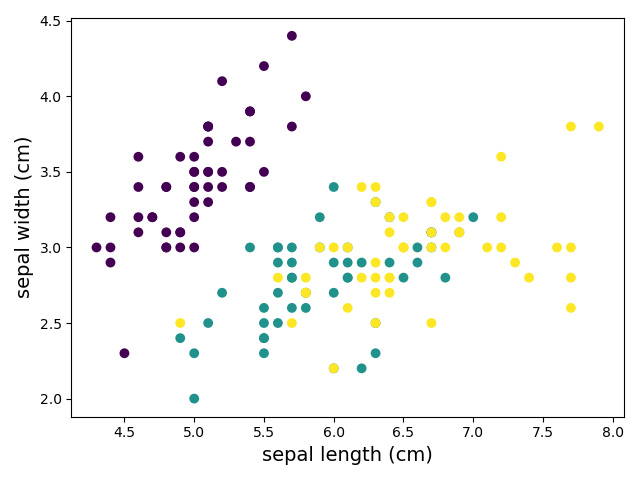

In [3]:
fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], 
           c = iris.target, s = 50, 
           edgecolor = "None", cmap = "viridis")
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

## Problem 2) $k$-means clustering

As a subfield of unsupervised learning, clustering aims to group/separate sources in the multidimensional feature space. The "unsupervised" comes from the fact that there are no target labels provided to the algorithm, so the machine is asked to cluster the data "on its own." The lack of labels means there is no (simple) method for validating the accuracy of the solution provided by the machine (though sometimes simple examination can show the results are **terrible**).


For this reason, "classic" unsupervised methods are not particularly useful for astronomy.$^\dagger$ Supposing one did find some useful clustering structure, an adversarial researcher could always claim that the current feature space does not accurately capture the physics of the system and as such the clustering result is not interesting or, worse, erroneous.

$^\dagger$This is my (AAM) opinion and there are many others who disagree.

We start today with the most famous, and simple, clustering algorithm: [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering). $k$-means clustering looks to identify $k$ convex clusters, where $k$ is a user defined number. And here-in lies the rub: if we truly knew the number of clusters in advance, we likely wouldn't need to perform any clustering in the first place. This is the major downside to $k$-means. 

As a reminder from lecture, the pseudocode for $k$-means: 

    initiate search by identifying k points (i.e. the cluster centers)
    loop 
        assign each data point to the closest cluster center
        update cluster centers based on mean location of cluster sources
        if diff(new center - old center) < threshold:
            stop (i.e. clusters are defined)

The threshold is defined by the user, though in some cases the total number of iterations can also be used as a stopping criteria. An advantage of $k$-means is that the solution will always converge, though the solution may only be a local minimum. Disadvantages include the assumption of convexity, i.e. difficult to capture complex geometry, and the curse of dimensionality (though as discussed in lecture it is possible to apply dimensionality reduction techniques prior to applying clustering).

In `scikit-learn` the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) algorithm is implemented as part of the [`sklearn.cluster`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module. 

**Problem 2a** 

Import `KMeans`

In [4]:
from sklearn.cluster import KMeans

**Problem 2b** 

Fit a $k = 2$, $k$-means model to the iris data. Plot the resulting clusters in the sepal length-sepal width plane.

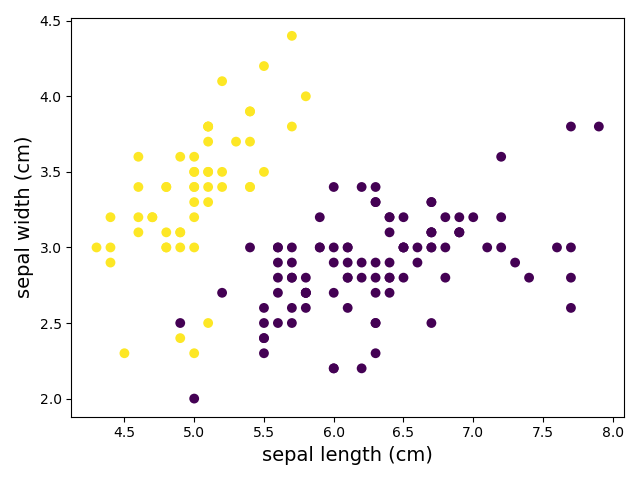

In [6]:
Kcluster = KMeans(n_clusters = 2, n_init='auto')
Kcluster.fit(iris.data)

fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], 
           c = Kcluster.labels_, s = 50, 
           edgecolor = "None", cmap = "viridis")
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

**Problem 2c** 

Fit a $k = 3$, $k$-means model to the iris data. Plot the resulting clusters in the sepal length-sepal width plane.

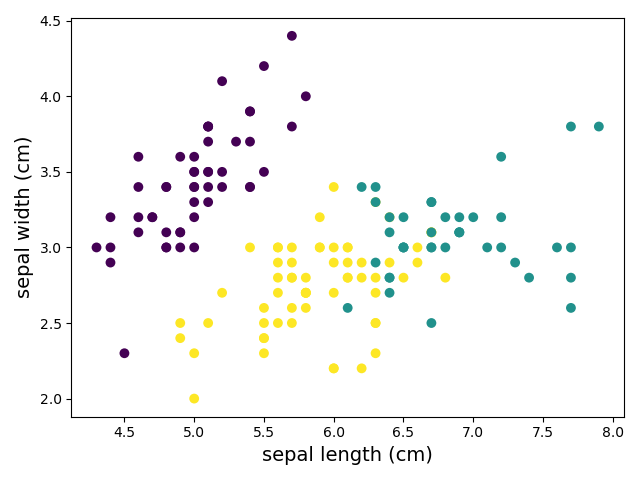

In [7]:
Kcluster = KMeans(n_clusters = 3, n_init='auto')
Kcluster.fit(iris.data)

fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], 
           c = Kcluster.labels_, s = 50, 
           edgecolor = "None", cmap = "viridis")
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

**Problem 2d**

Pretend that you do not know which iris sources belong to which class. Given this, which of the two clustering solutions ($k=2$ or $k=3$) would you identify as superior? 

Knowing that there are in fact 3 different clusters, which of the two clustering solutions would you identify as superior?

*write your answer here*

In the sepal width-sepal length plane there only seems to be one significant demarkation between the sources in the iris data set. Therefore, if I did not have a priori knowledge that there are 3 classes of iris flower, I would conclude that the $k = 2$ solution is superior. 

Given that I know there are 3 clusters, and I know where they are located, it is clear that the $k = 3$ solution is better. 

 **Problem 2e** 
 
How do the results change if the 3 cluster model is called with `n_init = 1` and `init = 'random'` options? Use `rs` for the random state [this allows me to cheat in service of making a point].

*Note - the respective defaults for these two parameters are `auto` and `k-means++`, respectively. Read the docs to see why these choices are, likely, better than those in 2e. 

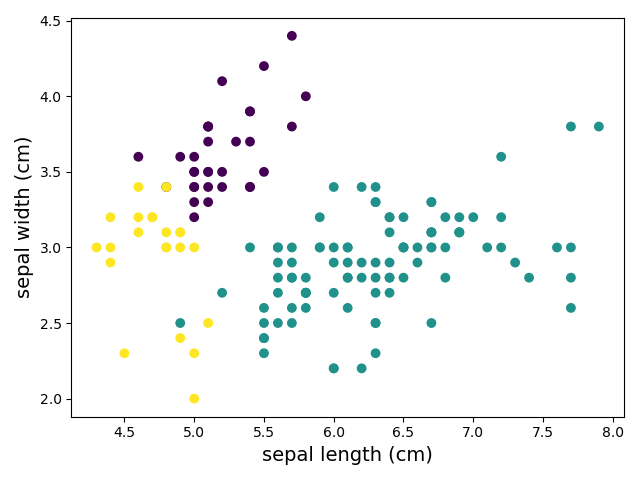

In [12]:
rs = 19
Kcluster1 = KMeans(n_clusters = 3, n_init = 1, init = 'random', random_state = rs)
Kcluster1.fit(iris.data)

fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], 
           c = Kcluster1.labels_, s = 50, 
           edgecolor = "None", cmap = "viridis")
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

That doesn't look right at all! 

So in addition to not knowing the correct number of clusters in the data, we see that the results are also sensitive to how the cluster positions are initiated. 

$k$-means evaluates the Euclidean distance between individual sources and cluster centers, thus, the magnitude of the individual features has a strong effect on the final clustering outcome.

**Problem 2f** 

Calculate the mean, standard deviation, min, and max of each feature in the iris data set. Based on these summaries, which feature is most important for clustering? 

In [8]:
print("feature\t\t\tmean\tstd\tmin\tmax")
for featnum, feat in enumerate(iris.feature_names):
    print("{:s}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(feat, np.mean(iris.data[:,featnum]), 
                                                        np.std(iris.data[:,featnum]), np.min(iris.data[:,featnum]),
                                                        np.max(iris.data[:,featnum])))

feature			mean	std	min	max
sepal length (cm)	5.84	0.83	4.30	7.90
sepal width (cm)	3.06	0.43	2.00	4.40
petal length (cm)	3.76	1.76	1.00	6.90
petal width (cm)	1.20	0.76	0.10	2.50


*write your answer here*

Petal length has the largest range and standard deviation, thus, it will have the most "weight" when determining the $k$ clusters.

Since $k$-means is built on Euclidean distance measures in the feature space, it can be really useful to re-scale all the features prior to applying the clustering algorithm. 

(Two notes – (a) some algorithms are extremely sensitive to feature scaling so this is a always a good thing to keep in mind, and (b) the iris data set is small and of relatively similar scale so the effects will not be that dramatic)

Imagine you are classifying stellar light curves: the data set will include binary white dwarf stars with periods of $\sim 0.01 \; \mathrm{d}$ and Mira variables with periods of $\sim 1000 \; \mathrm{d}$. Without re-scaling, this feature covers 6 orders of magnitude! Without rescaling all other features will add little weight to any final clustering solution.

The two most common forms of re-scaling are to rescale to a guassian with mean $= 0$ and variance $= 1$, or to rescale the min and max of the feature to $[0, 1]$. The best normalization is problem dependent. The [`sklearn.preprocessing`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) module makes it easy to re-scale the feature set.$^\dagger$  

$\dagger$ For supervised methods, **it is essential that the same scaling used for the training set be used for all other data run through the model.** The testing, validation, and field observations cannot be re-scaled independently. This would result in meaningless final classifications/predictions.

**Problem 2g** 

Re-scale the features to normal distributions, and perform $k$-means clustering on the iris data. How do the results compare to those obtained earlier? 

*Hint - you may find [`'StandardScaler()'`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) within the `sklearn.preprocessing` module useful.*

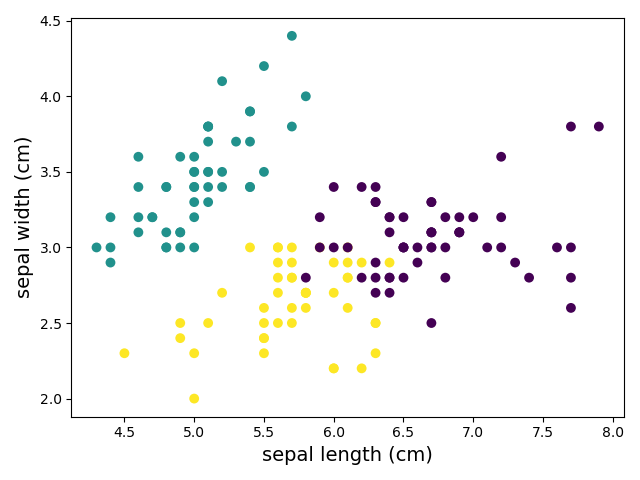

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(iris.data)

Kcluster = KMeans(n_clusters = 3, n_init='auto')
Kcluster.fit(scaler.transform(iris.data))

fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], c = Kcluster.labels_, s = 50, edgecolor = "None", cmap = "viridis")
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

*write your answer here*

These results are almost identical to those obtained without scaling. This is due to the simplicity of the iris data set. 

**How do I test the accuracy of my clusters?**

Essentially - you don't. There are some methods that are available, but they essentially compare clusters to labeled samples, and if the samples are labeled it is likely that supervised learning is more useful anyway. If you are curious, `scikit-learn` does provide some [built-in functions for analyzing clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), but again, it is difficult to evaluate the validity of any newly discovered clusters. 

**What if I don't know how many clusters are present in the data?**

An excellent question, as you will almost never know this a priori. Many algorithms, like $k$-means, do require the number of clusters to be specified, but some other methods do not.

## Problem 3) DBSCAN

[`DBSCAN`](https://en.wikipedia.org/wiki/DBSCAN) can be used to identify clusters without the pre-specification of the number of clusters to search for. 

In brief, `DBSCAN` requires two parameters: `minPts`, the minimum number of points necessary for a cluster, and $\epsilon$, a distance measure (see the lecture for the full pseudocode). 

The general downsides for DBSCAN are that the results are highly dependent on the two tuning parameters, and that clusters of highly different densities can be difficult to recover (because $\epsilon$ and `minPts` is specified for all clusters. 

In `scitkit-learn` the 
[`DBSCAN`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN) algorithm is part of the `sklearn.cluster` module. $\epsilon$ and `minPts` are set by `eps` and `min_samples`, respectively. 

**Problem 3a** 

Cluster the iris data using `DBSCAN`. Use the `scikit-learn` defaults. Plot the results in the sepal width-sepal length plane. 

*Note - DBSCAN labels outliers as $-1$, and thus, `plt.scatter()`, will plot all these points as the same color.*


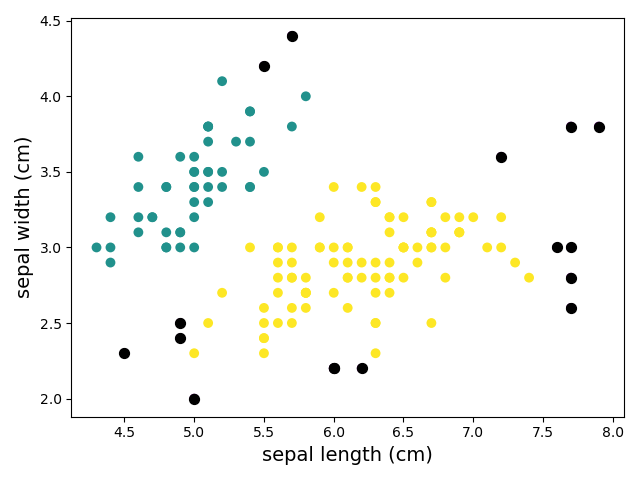

In [18]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.7, min_samples = 7)
dbs.fit(scaler.transform(iris.data)) # best to use re-scaled data since eps is in absolute units
dbs_outliers = dbs.labels_ == -1


fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], c = dbs.labels_, s = 50, edgecolor = "None", cmap = "viridis")
ax.scatter(iris.data[:,0][dbs_outliers], iris.data[:,1][dbs_outliers], s = 50, c = 'k')
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

**Problem 3b**

Adjust the tuning parameters to see how they affect the final clustering results. How does the use of `DBSCAN` compare to $k$-means? Can you obtain 3 clusters with `DBSCAN`? If not, given the knowledge that the iris dataset has 3 classes - does this invalidate `DBSCAN` as a viable algorithm?

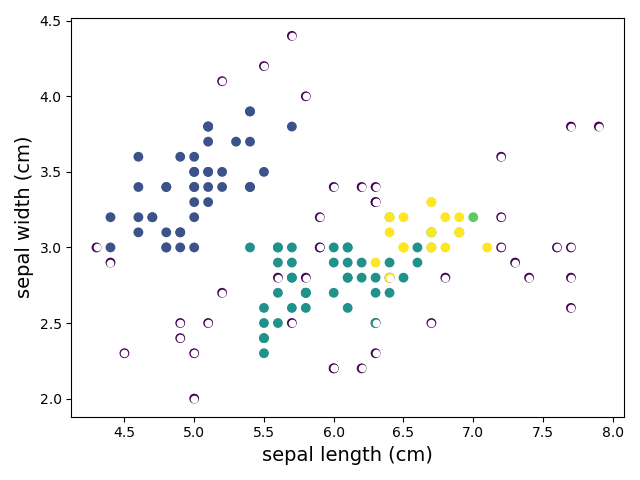

In [19]:
dbs = DBSCAN(eps = 0.5, min_samples = 6)
dbs.fit(scaler.transform(iris.data)) # best to use re-scaled data since eps is in absolute units

dbs_outliers = dbs.labels_ == -1

fig, ax = plt.subplots()
ax.scatter(iris.data[:,0], iris.data[:,1], c = dbs.labels_, s = 50, edgecolor = "None", cmap = "viridis")
ax.scatter(iris.data[:,0][dbs_outliers], iris.data[:,1][dbs_outliers], s = 20, c = 'white')
ax.set_xlabel('sepal length (cm)', fontsize=14)
ax.set_ylabel('sepal width (cm)', fontsize=14)
fig.tight_layout()

*write your answer here*

It is possible to obtain 3 clusters with `DBSCAN`, but the clusters do not do a particularly good job of identifying the 3 true classes that are present within the data.

For this problem it appears as though $k$-means is the superior algorithm. 

## Problem 4) Cluster SDSS Galaxy Data

The following query will select 10k likely galaxies from the SDSS database and return the results of that query into an [`astropy.Table`](http://docs.astropy.org/en/stable/table/) object. (For now, if you are not familiar with the SDSS DB schema, don't worry about this query, just know that it returns a bunch of photometric features.)

    from astroquery.sdss import SDSS  # enables direct queries to the SDSS database

    GALquery = """SELECT TOP 5000 
             p.dered_u - p.dered_g as ug, p.dered_g - p.dered_r as gr, 
             p.dered_g - p.dered_i as gi, p.dered_g - p.dered_z as gz,             
             p.petroRad_i, p.petroR50_i, p.deVAB_i, p.fracDev_i
             FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
             WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND p.type = 3
             AND p.deVAB_i > -999 AND p.petroRad_i > -999 AND p.petroR50_i > -999 AND p.dered_r < 20
               """
    SDSSgals = SDSS.query_sql(GALquery)
    SDSSgals

**Problem 4a** 

Download the [SDSS galaxy data](https://arch.library.northwestern.edu/downloads/7w62f868g?locale=en)

Read in the file `galaxy_clustering.csv`, and convert the data into a feature array `X`.

In [20]:
SDSSgals = pd.read_csv('galaxy_clustering.csv')

X = np.array(SDSSgals)

**Problem 4b** 

Using the SDSS galaxy data, identify interesting clusters within the data. This question is intentionally very open ended. If you uncover anything especially exciting you'll have a chance to share it with the group. Feel free to use the algorithms discussed above, or any other packages available via `sklearn`. Can you make sense of the clusters in the context of galaxy evolution? 

*Hint - don't fret if you know nothing about galaxy evolution (neither do I!). Just take a critical look at the clusters that are identified*

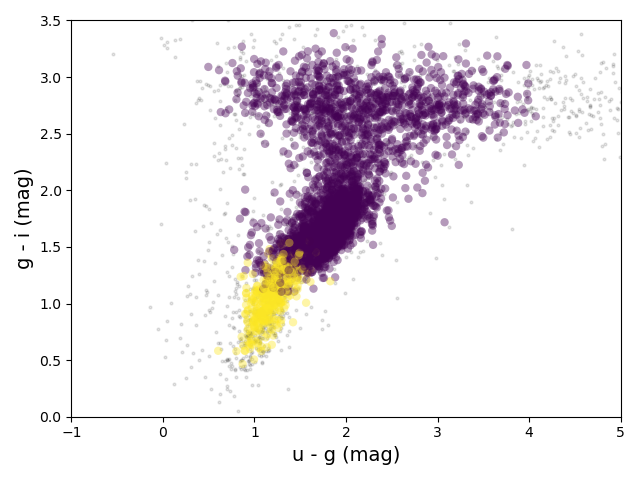

In [21]:
# potential solution with DBSCAN
galScaler = StandardScaler().fit(X)

dbs = DBSCAN(eps = 0.9, min_samples=100)
dbs.fit(galScaler.transform(X))

cluster_members = dbs.labels_ != -1
outliers = dbs.labels_ == -1

fig, ax = plt.subplots()
ax.scatter(X[:,0][outliers], X[:,3][outliers], 
            c = "k", 
            s = 4, alpha = 0.1)
ax.scatter(X[:,0][cluster_members], X[:,3][cluster_members], 
            c = dbs.labels_[cluster_members], 
            alpha = 0.4, edgecolor = "None", cmap = "viridis")

ax.set_xlabel('u - g (mag)', fontsize=14)
ax.set_ylabel('g - i (mag)', fontsize=14)
ax.set_xlim(-1,5)
ax.set_ylim(-0,3.5)
fig.tight_layout()

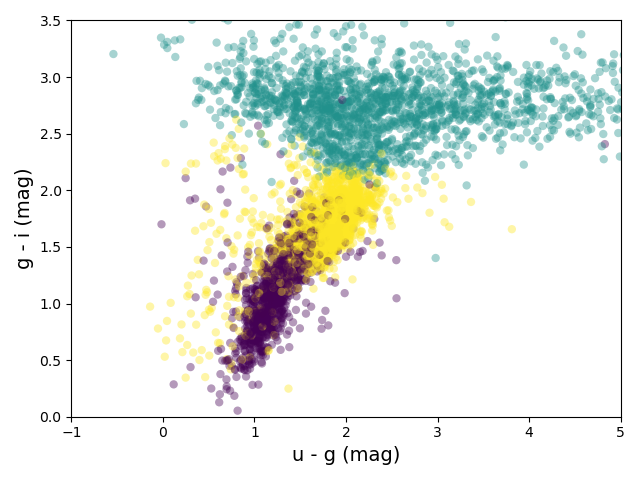

In [23]:
# potential solution with kmeans
kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(galScaler.transform(X))

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,3], 
            c = kmeans.labels_, 
            alpha = 0.4, edgecolor = "None", cmap = "viridis")

ax.set_xlabel('u - g (mag)', fontsize=14)
ax.set_ylabel('g - i (mag)', fontsize=14)
ax.set_xlim(-1,5)
ax.set_ylim(-0,3.5)
fig.tight_layout()

*write your thoughts about the identified clusters here*

There are two solutions shown above, one using DBSCAN and one using $k$-means (with $k$ = 3). 

Over the years I have learned A LOT about the SDSS targeting algorithm. For these data I think 3 clusters is a fairly reasonable solution. The bluest galaxies are star-forming galaxies at low redshift $z$. The "tight" cluster of red galaxies are passive galaxies at low-$z$. Finally the diffuse cloud at $g - i \approx 3$ are high-$z$ luminous red galaxies (LRGs) that were targeted for BAO measurements. These sources have a wide range of $u-g$ colors because they essentially are not detected in the $u$ band as this is blueward of the Lyman break. 

If you did not take the time to plot and examine each of the features in this data set, I suggest you look closely at the `fracDev_i` feature, which provides the most discriminating power for this clustering example. 